In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import re
from datetime import datetime

from Create_Profiles_Functions import *

quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}

def create_dimensionless_event(cumulative_rainfall):

    # Step 3: Normalize the cumulative rainfall by the total event depth
    total_event_depth = cumulative_rainfall[-1]
    normalized_cumulative_rainfall = np.array(cumulative_rainfall) / total_event_depth

    # Step 4: Calculate the cumulative event duration
    # Since each time step is 30 minutes, we multiply the index by 0.5 (for hours)
    time_step = 0.5  # 30 minutes = 0.5 hours
    cumulative_duration = np.arange(1, len(cumulative_rainfall) + 1) * time_step
    
    # Step 5: Normalize the cumulative duration by the total event duration
    total_event_duration = cumulative_duration[-1]
    normalized_cumulative_duration = cumulative_duration / total_event_duration
    
    normalized_cumulative_rainfall = np.insert(normalized_cumulative_rainfall, 0, 0)  # Adding 0 at the start
    normalized_cumulative_duration = np.insert(normalized_cumulative_duration, 0, 0)  
    
    return normalized_cumulative_rainfall, normalized_cumulative_duration

def redistribute(array_in,len_out):
    len_in=len(array_in)
    # Array going from 0 up to and including the number of original points
    in_bounds=np.arange(len_in+1)
    # Calculates the total accumulated value at each original point
    # Adds a zero for point zero
    csum=np.cumsum(np.hstack((np.array([0.]),array_in)))
    # Array of the "time points" corresponding to
    # Boundaries of output intervals
    out_bounds=np.arange(len_out+1)*(len_in/(1.0*len_out))
    # Interpolate total accumulated value to desired output points
    csum_out=np.interp(out_bounds,in_bounds,csum)
    # Interpolate back to accumulations over the desired number of intervals
    array_out=csum_out[1:]-csum_out[:-1]
    return array_out

### Get a rainfall event

In [18]:
gauge_num =1 
fp = '/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/NIMROD_30mins/NIMROD_2.2km_filtered_100/1/WholeYear/0.5hrs_2006_v2_part0.csv'
this_event = read_event(gauge_num, fp)
trimmed_event = remove_leading_and_trailing_zeroes(this_event)
real_trimmed_event, problem_events = remove_events_with_problems(trimmed_event, verbose=False)
len(real_trimmed_event)

3

In [3]:
gauge_num =1 
fp = '/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/NIMROD_30mins/NIMROD_2.2km_filtered_100/1292/WholeYear/6hrs_2020_v2_part0.csv'
this_event = read_event(gauge_num, fp)
trimmed_event = remove_leading_and_trailing_zeroes(this_event)
real_trimmed_event, problem_events = remove_events_with_problems(trimmed_event, verbose=False)
len(real_trimmed_event)

31

## Get a dimensionless version of event and plot

In [49]:
precip = real_trimmed_event['precipitation (mm)']
cumulative_rainfall = create_cumulative_event(precip)
dimensionless_cumulative_rainfall, dimensionless_cumulative_duration = create_dimensionless_event(cumulative_rainfall)
dimensionless_incremental_rainfall  = create_incremental_event(dimensionless_cumulative_rainfall)

In [100]:
# # Include the starting point (0 value for cumulative data)
# dimensionless_cumulative_rainfall = np.insert(dimensionless_cumulative_rainfall, 0, 0)  # Adding 0 at the start
# dimensionless_cumulative_duration = np.insert(dimensionless_cumulative_duration, 0, 0)  # Adding 0 at the start

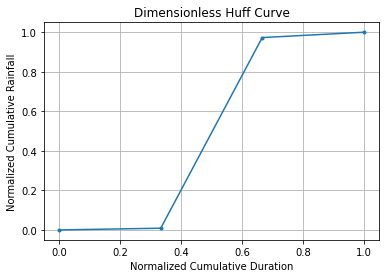

In [21]:
# Step 6: Plot the dimensionless Huff curve
plt.plot(dimensionless_cumulative_duration, dimensionless_cumulative_rainfall, marker='.')
plt.xlabel('Normalized Cumulative Duration')
plt.ylabel('Normalized Cumulative Rainfall')
plt.title('Dimensionless Huff Curve')
plt.grid(True)
plt.show()

### See how long the event is

In [7]:
len(dimensionless_cumulative_rainfall)

32

### Steef method

In [8]:
def redistribute(array_in,len_out):
    len_in=len(array_in)
    # Array going from 0 up to and including the number of original points
    in_bounds=np.arange(len_in+1)
    # Calculates the total accumulated value at each original point
    # Adds a zero for point zero
    csum=np.cumsum(np.hstack((np.array([0.]),array_in)))
    # Array of the "time points" corresponding to
    # Boundaries of output intervals
    out_bounds=np.arange(len_out+1)*(len_in/(1.0*len_out))
    # Interpolate total accumulated value to desired output points
    csum_out=np.interp(out_bounds,in_bounds,csum)
    # Interpolate back to accumulations over the desired number of intervals
    array_out=csum_out[1:]-csum_out[:-1]
    return array_out

def redistribute_cumulative(cumulative_rainfall, len_out):
    len_in = len(cumulative_rainfall)
    
    # Array going from 0 up to and including the number of original points
    in_bounds = np.arange(len_in)
    
    # Array of the "time points" corresponding to boundaries of output intervals
    out_bounds = np.linspace(0, len_in-1, len_out)
    
    # Interpolate cumulative rainfall to the desired output points
    cumulative_out = np.interp(out_bounds, in_bounds, cumulative_rainfall)
    
    return cumulative_out

### Split into 12 equally spaced bins - using bin centres

In [136]:
def old_bin_centres(dimensionless_cumulative_duration, dimensionless_cumulative_rainfall):
    bins = np.linspace(0, 1, 13)  # 12 bins means 13 edges

    #  Find within each of these bins each value falls
    bin_indices = np.digitize(dimensionless_cumulative_duration, bins) - 1  # bin_indices from 0 to 11

    # Initialize arrays for binned duration and rainfall
    binned_duration = np.linspace(0, 1, 12)  # Midpoints of each bin
    binned_rainfall = np.zeros(12)

    # Fill in binned rainfall values by averaging values that fall into each bin
    for i in range(12):
        indices_in_bin = np.where(bin_indices == i)[0]
        if len(indices_in_bin) > 0:
            binned_rainfall[i] = np.mean(dimensionless_cumulative_rainfall[indices_in_bin])
        else:
            binned_rainfall[i] = np.nan  # Mark empty bins with NaN for interpolation

    # Step 8: Interpolate to fill in any empty bins (NaN values)
    nan_indices = np.isnan(binned_rainfall)
    interp_func = interp1d(binned_duration[~nan_indices], binned_rainfall[~nan_indices], kind='linear', fill_value="extrapolate")
    binned_rainfall[nan_indices] = interp_func(binned_duration[nan_indices])
    
    return binned_duration, binned_rainfall

def using_bin_edges(dimensionless_cumulative_duration, dimensionless_cumulative_rainfall, clip_zeroes= True):

    # Define 13 bin edges for 12 intervals (this includes a 0)
    bins = np.linspace(0, 1, 13)  # 13 edges create 12 intervals

    # Interpolate cumulative rainfall to the bin edges
    # Includes a 0 and a 1 value, 13 values total
    interp_func = interp1d(dimensionless_cumulative_duration, dimensionless_cumulative_rainfall, kind='linear', fill_value="extrapolate")
    binned_rainfall = interp_func(bins)

    # Step 8: Since we're working with cumulative data, calculate the midpoint of each bin for plotting
    #binned_duration_new = (bins[:-1] + bins[1:]) / 2  # Midpoints of each bin interval

    # Ensure no negative values in the rainfall data
    if clip_zeroes == True:
        binned_rainfall = np.clip(binned_rainfall, a_min=0, a_max=None)
    
    return bins, binned_rainfall

def using_bin_edges(dimensionless_cumulative_duration, dimensionless_cumulative_rainfall, clip_zeroes= True):

    # Define 13 bin edges for 12 intervals (this includes a 0)
    bins = np.linspace(0, 1, 13)  # 13 edges create 12 intervals

    # Interpolate cumulative rainfall to the bin edges
    # Includes a 0 and a 1 value, 13 values total
    interp_func = interp1d(dimensionless_cumulative_duration, dimensionless_cumulative_rainfall, kind='linear', fill_value="extrapolate")
    binned_rainfall = interp_func(bins)

    # Step 8: Since we're working with cumulative data, calculate the midpoint of each bin for plotting
    binned_midpoints = (bins[:-1] + bins[1:]) / 2  # Midpoints of each bin interval

    # Ensure no negative values in the rainfall data
    if clip_zeroes == True:
        binned_rainfall = np.clip(binned_rainfall, a_min=0, a_max=None)
    
    return bins, binned_rainfall, binned_midpoints



def interpolate_rainfall(rainfall, bin_number):
    if rainfall is None or len(rainfall) < 2:
        return None

    # Define target points for bin_number bins
    target_points = np.linspace(0, 1, 13)
    
    # Create interpolation function based on existing data points
    rainfall_times = np.array(range(0, len(rainfall)))

    # Normalize time from 0 to 1
    normalized_time = (rainfall_times - rainfall_times[0]) / (rainfall_times[-1] - rainfall_times[0])
    interpolation_func = interp1d(normalized_time, rainfall, kind='linear', fill_value="extrapolate")
    
    # Interpolate values at target points
    interpolated_values = interpolation_func(target_points)
    
    return interpolated_values


### Split into 12 equally spaced bins - using bin edges

In [135]:
# # Step 9: Plot the dimensionless Huff curve with 12 bins
# bins, binned_rainfall, binned_midpoints = using_bin_edges(dimensionless_cumulative_duration, dimensionless_cumulative_rainfall, True)
# plt.plot(bins, binned_rainfall, marker='o', linestyle='-', color='b')

# binned_duration, binned_rainfall = old_bin_centres(dimensionless_cumulative_duration, dimensionless_cumulative_rainfall)
# plt.plot(binned_duration, binned_rainfall, marker='o', linestyle='-', color='g')

# int_rainfall = interpolate_rainfall(dimensionless_cumulative_rainfall,12)
# plt.plot(bins, int_rainfall, marker='o', linestyle='-', color='black')

# plt.xlabel('Normalized Cumulative Duration (Midpoints)')
# plt.ylabel('Normalized Cumulative Rainfall')
# plt.title('Dimensionless Huff Curve with 12 Bins')
# plt.grid(True)
# plt.show()


In [137]:
# # Initialize an empty DataFrame with the desired columns
# Initialize an empty DataFrame with the desired columns
columns = [
    'gauge_num',  'season', 'precip',
    # 'normalized_rainfall', 'cumulative_normalized_rainfall',
    'cumulative_rainfall', 'dimensionless_rainfall', "dimensionless_time",
    'bins', 'binned_rainfall','binned_duration_centres', 'binned_rainfall_centres', 'int_rainfall'
   # 'interpolated15_cumulative_rainfall', 'interpolated12_cumulative_rainfall','interpolated15_incremental_rainfall','interpolated12_incremental_rainfall',
   # 'interpolated15_cumulative_normalized_rainfall','interpolated12_cumulative_normalized_rainfall','interpolated15_incremental_normalized_rainfall','interpolated12_incremental_normalized_rainfall',
    #'max_quintile_raw_rain','max_quintile_profile_12', 'max_quintile_profile_15', 'max_quintile_normalised_rain', 'max_quintile_profile_12_norm', "max_quintile_profile_15_norm"
]
df = pd.DataFrame(columns=columns)

for nimrod_option in ["NIMROD_2.2km_filtered_100"]:
    for gauge_num in range(0, 3):
        if gauge_num not in [444, 827, 888]:
            print(f"gauge {gauge_num}")
            files = [f for f in os.listdir(f"/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/NIMROD_30mins/{nimrod_option}/{gauge_num}/WholeYear") if f.endswith('.csv')]
            files = np.sort(files)

            for file in files:
                fp = f"/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/NIMROD_30mins/{nimrod_option}/{gauge_num}/WholeYear/{file}"
                if '2080' in fp:
                    continue

                this_event = read_event(gauge_num, fp)
                trimmed_event = remove_leading_and_trailing_zeroes(this_event)
                real_trimmed_event, problem_events = remove_events_with_problems(trimmed_event, verbose=False)

                if real_trimmed_event is not None:
                    
                    precip = real_trimmed_event['precipitation (mm)']
                    #normalized_rainfall = create_normalised_event(real_trimmed_event['precipitation (mm)'])
                    #cumulative_normalized_rainfall = create_cumulative_event(normalized_rainfall)
                    cumulative_rainfall = create_cumulative_event(precip)
                    dimensionless_cumulative_rainfall, dimensionless_cumulative_duration =  create_dimensionless_event(cumulative_rainfall)
                    
                    bins, binned_rainfall, binned_midpoints = using_bin_edges(dimensionless_cumulative_duration, dimensionless_cumulative_rainfall, True)
                    binned_duration_centres, binned_rainfall_centres = old_bin_centres(dimensionless_cumulative_duration, dimensionless_cumulative_rainfall)
                    int_rainfall = interpolate_rainfall(dimensionless_cumulative_rainfall,12)
                    
                else:
                    precip=trimmed_event['precipitation (mm)']
                    #normalized_rainfall = None
                    #cumulative_normalized_rainfall = None
                    cumulative_rainfall = None
                    dimensionless_rainfall = None
                    dimensionless_time = None
                    bins = None
                    binned_rainfall = None
                    binned_duration_centres = None
                    binned_rainfall_centres=None
                    int_rainfall = None

                    
                # Append the row to the DataFrame
                df = df.append({
                    'gauge_num': gauge_num,

                    'precip': precip.values,
                    
                    # 'normalized_rainfall':normalized_rainfall,
                    #'cumulative_normalized_rainfall':cumulative_normalized_rainfall,
                    'cumulative_rainfall':cumulative_rainfall,
                    'dimensionless_rainfall':dimensionless_rainfall,
                    'dimensionless_time':dimensionless_time,
                    "bins" : bins,
                    "binned_rainfall" : binned_rainfall,
                    "binned_duration_centres" : binned_duration_centres,
                    "binned_rainfall_centres":binned_rainfall_centres,
                    'int_rainfall':int_rainfall

         
                }, ignore_index=True)
                

                    

gauge 0
gauge 1
gauge 2


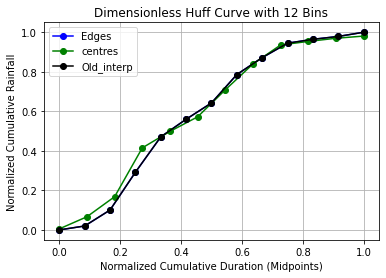

In [140]:
row_num =210
bins = df['bins'][row_num]
binned_rainfall = df['binned_rainfall'][row_num]
binned_duration_centres = df['binned_duration_centres'][row_num]
binned_rainfall_centres = df['binned_rainfall_centres'][row_num]
int_rainfall= df['int_rainfall'][row_num]
# binned_duration = df['binned_duration'][0]

plt.plot(bins, binned_rainfall, marker='o', linestyle='-', color='b', label = 'Edges')
plt.plot(binned_duration_centres, binned_rainfall_centres, marker='o', linestyle='-', color='g', label='centres')
plt.plot(bins, int_rainfall, marker='o', linestyle='-', color='black', label = 'Old_interp')

plt.xlabel('Normalized Cumulative Duration (Midpoints)')
plt.ylabel('Normalized Cumulative Rainfall')
plt.title('Dimensionless Huff Curve with 12 Bins')
plt.legend()
plt.grid(True)
plt.show()
